In [1]:
from datetime import datetime, timedelta, date
import time
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report,confusion_matrix
from scipy.sparse import csr_matrix, hstack
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

# Goal
Here we are looking at the Telco Customer Churn data from kaggle avaiable [here](https://www.kaggle.com/blastchar/telco-customer-churn). Everything needed to make a good Churn predictor is avaiable here: frequency/monthly charges, total charges, and tenure.  In addition there is some demographic information about the customers - let's dive in! 

 # Import Data

In [4]:
cwd = os.getcwd()
data = pd.read_csv(os.path.join(cwd, "data", "WA_Fn-UseC_-Telco-Customer-Churn.csv"))
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [6]:
data = data.dropna(how="all")  
data.shape

(7043, 21)

In [7]:
data = data[~data.duplicated()] 
data.shape

(7043, 21)

No duplicates or NaN rows, however TotalCharges should not be an object.  Let's remove the rows with empty charge data.

In [8]:
mask = data.TotalCharges == " "
data = data[~mask]
data.shape

(7032, 21)

In [9]:
data.TotalCharges = pd.to_numeric(data.TotalCharges)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Lets plot histograms of the three numerical features most relevant to Churn Rate.  Both before and after separated based on the Churn predictor

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019D5F4E9358>,
      dtype=object)

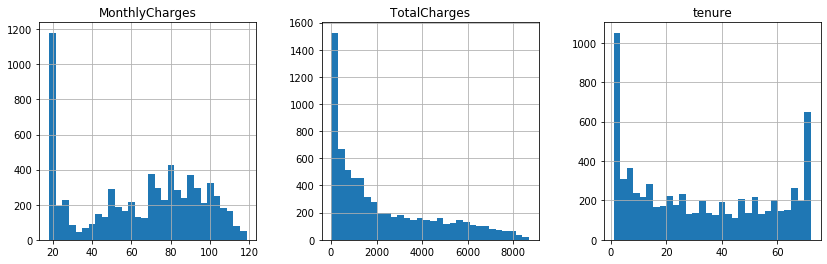

In [10]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
data[numerical_features].hist(bins=30, figsize=(10, 7), ax=ax)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019D5FAE6550>,
      dtype=object)

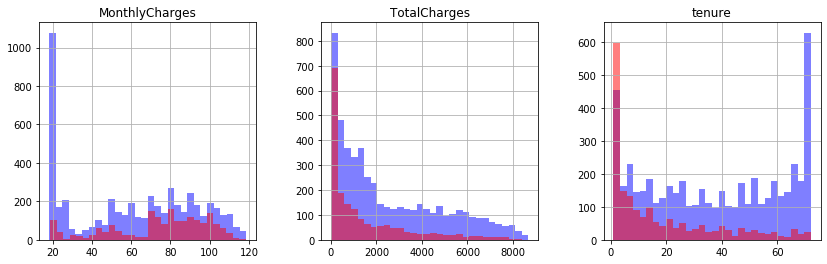

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
data[data.Churn == "No"][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
data[data.Churn == "Yes"][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

Looks like it would be a good idea to cluster these customers.  Lets do some unsupervised learning and find out what the optimal cluster size is

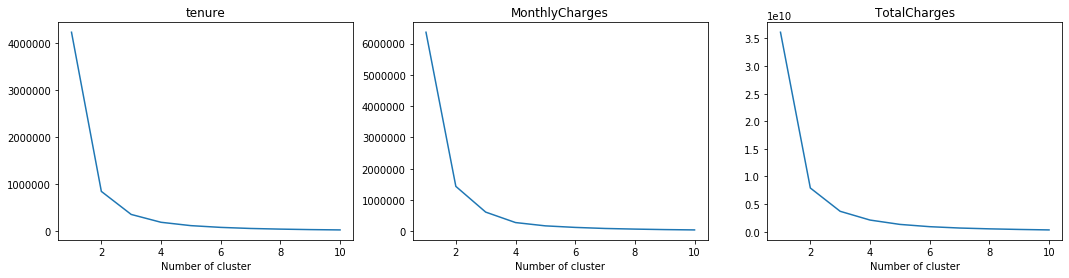

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

for i, feature in enumerate(numerical_features):
    wsse={}
    data_cluster = data[[feature]]
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_cluster)
        wsse[k] = kmeans.inertia_ 
    ax[i].plot(list(wsse.keys()), list(wsse.values()))
    ax[i].set_title(feature)
    ax[i].set_xlabel("Number of cluster")
plt.show()

The elbow is at 3 for each of the 3 numerical features.  We could look further into this to see if some are highly correlated to one another or if they are ordered relative to company value.  If they are ordered it would be a good idea to encode them and additionally to create a superscore of the 3 features as another feature.  For now we will simply go with them as dummy vaariables.  

In [14]:
k = [3, 3, 3]
k_dic = dict(zip(numerical_features, k))

for feature in k_dic:
    kmeans = KMeans(n_clusters=k_dic[feature], max_iter=1000).fit(data_cluster)
    kmeans.fit(data[[feature]])
    data[feature + "Cluster"] = kmeans.labels_

In [15]:
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns

for column in data.columns:
    if (data[column].dtype == object and column != 'customerID') or ("Cluster" in column):
        if data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            data[column] = le.fit_transform(data[column]) 
        else:
            dummy_columns.append(column)

#apply get dummies for selected columns
data = pd.get_dummies(data=data, columns=dummy_columns)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,PaymentMethod_Mailed check,tenureCluster_0,tenureCluster_1,tenureCluster_2,MonthlyChargesCluster_0,MonthlyChargesCluster_1,MonthlyChargesCluster_2,TotalChargesCluster_0,TotalChargesCluster_1,TotalChargesCluster_2
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,...,0,0,1,0,0,0,1,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,...,1,0,0,1,1,0,0,0,1,0
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,...,1,0,1,0,1,0,0,0,1,0
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,...,0,0,0,1,0,0,1,0,1,0
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,...,0,0,1,0,1,0,0,0,1,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 51 columns):
customerID                                 7032 non-null object
gender                                     7032 non-null int32
SeniorCitizen                              7032 non-null int64
Partner                                    7032 non-null int32
Dependents                                 7032 non-null int32
tenure                                     7032 non-null int64
PhoneService                               7032 non-null int32
PaperlessBilling                           7032 non-null int32
MonthlyCharges                             7032 non-null float64
TotalCharges                               7032 non-null float64
Churn                                      7032 non-null int32
MultipleLines_No                           7032 non-null uint8
MultipleLines_No phone service             7032 non-null uint8
MultipleLines_Yes                          7032 non-null uint8
Intern

In [17]:
X = data.drop(['Churn', 'customerID'], axis=1)
y = data.Churn.values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [19]:
X_train = lgb.Dataset(X_train, label=y_train)

In [20]:
progress = {}
watchlist  = [(X_train,'train-rmse'), (eval, 'eval-rmse')]

params = {
        'learning_rate': 0.08,
        'application': 'regression',
        'max_depth': 5,
        'num_leaves': 100,
        'min_data_in_leaf':1000,
        'verbosity': -1,
        'metric': 'RMSE',
    }

In [21]:
gbm = lgb.train(params, train_set=X_train, num_boost_round=3200, verbose_eval=100, evals_result=progress)

In [22]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [23]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.3506681863713007


This model gives strong precision and recall for the not Churning label.  Nice, from a business perspective we could focus on the customers predicted to not Churn in a business model.  Additionally, we could do more exploratory analysis on users!

In [24]:
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       259
           1       0.71      0.61      0.66        93

    accuracy                           0.83       352
   macro avg       0.79      0.76      0.77       352
weighted avg       0.83      0.83      0.83       352



As expected, the three values coined to be most important from the start have the greatest feature importance in the model.  Interestingly, gender is actually more important than the rest of the features by a considerable margin.  I would have personally expected the Senior feature to have more importance.

Plotting feature importances...


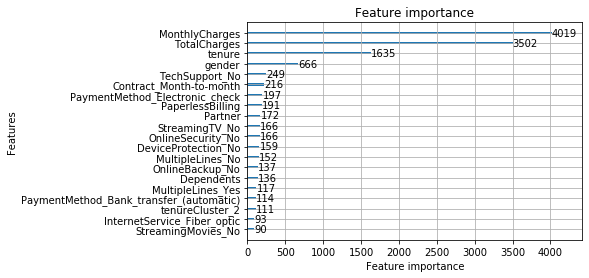

In [25]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=20)
plt.show()